In [282]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import make_interp_spline

#Author: Mohammed Mohideen
# Financial Portfolio Optimization with Artificial Bee Colony 

# Objective Function
## Pareto Frontier of Sharpe Ratio and ESG Score

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\sum_{i=1}^n w_i \mu_i - R_f}{\sqrt{w^T \Sigma w}}
$$

Where:
- $μ_i$ = Portfolio return  
- $R_f$ = Risk-free rate  
- $σ_p$ = Portfolio volatility (standard deviation)
- $Σw$	= Covariance matrix

In [43]:
# gather ticker info from Alpha Vantage API
API_KEY = "OD76BXNCWU9GO4WP"
symbols = ["MSFT", "AAPL", "NVDA", "UNH", "JNJ"]
test = ["FNCMX", "FSELX", "FSPGX", "FTIHX", "FXAIX", "FZROX"]

weights = []

esg_scores = [85,80,75,70,65]

def fetch_daily_prices(ticker):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": ticker,
        "apikey": API_KEY,
        "outputsize": "full"
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check for valid time series key
    time_series_key = next((key for key in data if "Time Series" in key), None)
    if not time_series_key:
        print(f"[Error] No time series for {ticker}. Response: {data}")
        return pd.Series(dtype=float)  # Empty series

    df = pd.DataFrame(data[time_series_key]).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df["close"] = df["4. close"].astype(float)

    return df["close"].iloc[-1260:]  # Last 5 years of trading days

def fetch_all_prices(symbols, output_file="daily_close_prices.csv"):
    all_prices = {}

    for i, symbol in enumerate(symbols):
        print(f"[{i+1}/{len(symbols)}] Fetching {symbol}...")
        all_prices[symbol] = fetch_daily_prices(symbol)

    df = pd.DataFrame(all_prices)
    df.to_csv(output_file)
    print(f"\n Saved data to {output_file}")
    return df

In [30]:

df_prices = fetch_all_prices(symbols)

[1/5] Fetching MSFT...
[2/5] Fetching AAPL...
[3/5] Fetching NVDA...
[4/5] Fetching UNH...
[5/5] Fetching JNJ...

 Saved data to daily_close_prices.csv


In [45]:
cached_5prices = df_prices
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    # Ensure weights are non-negative and sum to 1
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    # Calculate daily returns
    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    # Portfolio return
    portfolio_return = np.dot(weights, mean_annual_returns)

    # Portfolio volatility (handling zero variance case)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        print(f"[Warning] Zero or negative portfolio variance for weights: {weights}")
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)

    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)

    # ESG score
    esg_score = np.dot(weights, esg_vector)

    return sharpe_ratio, esg_score

In [356]:
def dominates(a, b, epsilon=1e-6):
    """
    Efficient dominance check with a small tolerance.
    """
    strictly_better = False
    for x, y in zip(a, b):
        if x < y - epsilon:
            return False  # Early exit if a is not better in any dimension
        elif x > y + epsilon:
            strictly_better = True

    return strictly_better
    
def update_pareto_archive(archive, candidate_objectives, candidate_weights, precision=3):
    """
    Archive update with rounded comparison to avoid floating-point duplicates.
    Stores full-precision solutions, but uses rounded objectives for uniqueness.
    """
    candidate_key = tuple(np.round(candidate_objectives, precision))
    candidate_tuple = (*candidate_objectives, tuple(candidate_weights))

    # Check if candidate (rounded) is already in the archive
    archive_keys = [tuple(np.round((s, e), precision)) for s, e, w in archive]
    if candidate_key in archive_keys:
        return archive

    # Filter archive using domination logic (full precision)
    filtered_archive = []
    for (s, e, w) in archive:
        if dominates((s, e), candidate_objectives):
            return archive  # Candidate is dominated
        if not dominates(candidate_objectives, (s, e)):
            filtered_archive.append((s, e, w))  # Keep non-dominated

    # Add the new candidate
    filtered_archive.append(candidate_tuple)
    return filtered_archive

def normalize_weights(w, min_weight=0.01, max_weight=0.3):
    # Leniently enforce minimum and maximum weight
    w = np.clip(w, min_weight, max_weight)
    return w / np.sum(w)
    
def initialize_population(num_bees, prices_df, esg_vector):
    num_assets = prices_df.shape[1]  # number of stocks

    foods = []
    objectives = []
    trials = np.zeros(num_bees)
    pareto_archive = []

    for _ in range(num_bees):
        # Step 1: Generate random weight vector
        weights = normalize_weights(0.1 + 0.9 * np.random.rand(num_assets))

        # Step 2: Evaluate objectives (Sharpe, ESG)
        sharpe, esg = evaluate_objectives(weights, prices_df, esg_vector)

        # Step 3: Add to food list and objectives
        foods.append(weights)
        objectives.append((sharpe, esg))

        # Step 4: Update Pareto archive
        pareto_archive = update_pareto_archive(pareto_archive, (sharpe, esg), weights)
    return foods, objectives, trials, pareto_archive
    
def employed_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        # Step 1: Pick a random parameter (asset weight) to mutate
        param2change = random.randint(0, num_assets - 1)

        # Step 2: Pick a different random neighbor bee
        neighbour = random.randint(0, num_bees - 1)
        while neighbour == i:
            neighbour = random.randint(0, num_bees - 1)

        # Step 3: Generate new solution by ABC mutation formula
        phi = (random.random() - 0.5) * 2
        candidate = np.copy(foods[i])
        candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

        # Step 4: Clip and normalize the candidate
        candidate = normalize_weights(candidate)
        # Step 5: Evaluate objectives
        new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

        # Step 6: Compare and decide
        if dominates(new_objectives, objectives[i]):
            # Accept new solution
            foods[i] = candidate
            objectives[i] = new_objectives
            trials[i] = 0
        else:
            trials[i] += 1  # No improvement

        # Step 7: Update Pareto archive regardless
        pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

    return foods, objectives, trials, pareto_archive

def compute_probabilities(objectives):
    sharpes = [s for s, e in objectives]
    esgs = [e for s, e in objectives]

    # Normalize to [0, 1]
    sharpes_norm = [(s - min(sharpes)) / (max(sharpes) - min(sharpes) + 1e-8) for s in sharpes]
    esgs_norm = [(e - min(esgs)) / (max(esgs) - min(esgs) + 1e-8) for e in esgs]

    # Combine them
    scores = [(0.5 * s + 0.5 * e) for s, e in zip(sharpes_norm, esgs_norm)]
    total = sum(scores)
    probabilities = [s / total for s in scores]
    return probabilities

def onlooker_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])
    probabilities = compute_probabilities(objectives)

    i = 0
    t = 0
    while t < num_bees:
        if random.random() < probabilities[i]:
            t += 1

            # Mutation
            param2change = random.randint(0, num_assets - 1)
            neighbour = random.randint(0, num_bees - 1)
            while neighbour == i:
                neighbour = random.randint(0, num_bees - 1)

            phi = (random.random() - 0.5) * 2
            candidate = np.copy(foods[i])
            candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

            candidate = normalize_weights(candidate)

            new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

            if dominates(new_objectives, objectives[i]):
                foods[i] = candidate
                objectives[i] = new_objectives
                trials[i] = 0
            else:
                trials[i] += 1

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

        i = (i + 1) % num_bees

    return foods, objectives, trials, pareto_archive

def scout_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit=10):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        if trials[i] >= limit:
            # Replace this food source with a new random one
            new_weights = 0.1 + 0.2 * np.random.rand(num_assets)
            new_weights = new_weights / np.sum(new_weights)

            new_objectives = evaluate_objectives(new_weights, prices_df, esg_vector)

            foods[i] = new_weights
            objectives[i] = new_objectives
            trials[i] = 0  # reset trial count

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, new_weights)

    return foods, objectives, trials, pareto_archive
    
def plot_pareto_archive(archive):
    sharpes = [s for s, e, _ in archive]
    esgs = [e for s, e, _ in archive]

    plt.figure(figsize=(6, 4))
    plt.scatter(esgs, sharpes, alpha=0.6)
    plt.xlabel("ESG Score")
    plt.ylabel("Sharpe Ratio")
    plt.title(f"Pareto Frontier")
    plt.grid(True)
    plt.show()

def run_abc(prices_df, esg_vector, num_bees=20, max_cycles=100, limit=10, patience=15):
    # Init phase 
    foods, objectives, trials, pareto_archive = initialize_population(
        num_bees, prices_df, esg_vector
    )

    cycle = 0
    no_change_count = 0
    prev_archive_objs = set()

    while cycle < max_cycles and no_change_count < patience:
        # Employed Phase 
        foods, objectives, trials, pareto_archive = employed_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Onlooker Phase 
        foods, objectives, trials, pareto_archive = onlooker_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Scout Phase 
        foods, objectives, trials, pareto_archive = scout_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit
        )


        # Check for Convergence
        current_objs = set((round(s, 4), round(e, 4)) for s, e, _ in pareto_archive)
        if current_objs == prev_archive_objs:
            no_change_count += 1
        else:
            no_change_count = 0
            prev_archive_objs = current_objs

        cycle += 1

    return pareto_archive

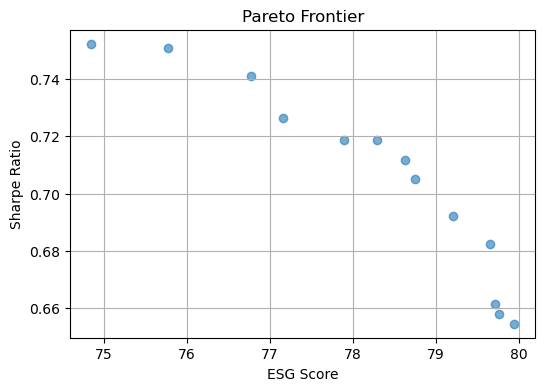

In [358]:
esg_vector = np.array(esg_scores)
pareto_test = run_abc(df_prices, esg_scores, num_bees = 20, max_cycles = 100, limit = 15, patience = 20)
plot_pareto_archive(pareto_test)

In [360]:
sorted_by_sharpe = sorted(pareto_test, key=lambda x: x[0], reverse=True)
sorted_by_esg = sorted(pareto_test, key=lambda x: x[1], reverse=True)
for sharpe, esg, weights in sorted_by_esg:
    print(f"Sharpe: {sharpe:.3f}, ESG: {esg:.1f}, Weights: {np.round(weights, 2)}")

Sharpe: 0.655, ESG: 79.9, Weights: [0.34 0.34 0.29 0.01 0.01]
Sharpe: 0.658, ESG: 79.8, Weights: [0.33 0.33 0.32 0.01 0.01]
Sharpe: 0.661, ESG: 79.7, Weights: [0.33 0.32 0.33 0.01 0.01]
Sharpe: 0.682, ESG: 79.7, Weights: [0.35 0.27 0.34 0.02 0.01]
Sharpe: 0.692, ESG: 79.2, Weights: [0.35 0.24 0.35 0.01 0.04]
Sharpe: 0.705, ESG: 78.7, Weights: [0.36 0.21 0.3  0.08 0.05]
Sharpe: 0.712, ESG: 78.6, Weights: [0.35 0.17 0.35 0.1  0.02]
Sharpe: 0.719, ESG: 78.3, Weights: [0.35 0.13 0.36 0.15 0.01]
Sharpe: 0.719, ESG: 77.9, Weights: [0.38 0.19 0.24 0.02 0.18]
Sharpe: 0.727, ESG: 77.2, Weights: [0.36 0.14 0.27 0.04 0.19]
Sharpe: 0.741, ESG: 76.8, Weights: [0.37 0.01 0.37 0.11 0.14]
Sharpe: 0.751, ESG: 75.8, Weights: [0.35 0.01 0.29 0.12 0.23]
Sharpe: 0.752, ESG: 74.8, Weights: [0.34 0.01 0.23 0.1  0.31]


In [362]:
def display_archive(archive, title="Pareto Archive (Sorted)"):
    print(f"\n{title}")
    print("-" * 50)
    for i, (sharpe, esg, weights) in enumerate(archive):
        w_str = ", ".join(f"{w:.2f}" for w in weights)
        print(f"[{i+1}] Sharpe: {sharpe:.4f} | ESG: {esg:.2f} | Weights: [{w_str}]")
display_archive(sorted_by_sharpe, title="Top Portfolios by Sharpe")



Top Portfolios by Sharpe
--------------------------------------------------
[1] Sharpe: 0.7524 | ESG: 74.85 | Weights: [0.34, 0.01, 0.23, 0.10, 0.31]
[2] Sharpe: 0.7508 | ESG: 75.77 | Weights: [0.35, 0.01, 0.29, 0.12, 0.23]
[3] Sharpe: 0.7411 | ESG: 76.77 | Weights: [0.37, 0.01, 0.37, 0.11, 0.14]
[4] Sharpe: 0.7265 | ESG: 77.16 | Weights: [0.36, 0.14, 0.27, 0.04, 0.19]
[5] Sharpe: 0.7188 | ESG: 77.89 | Weights: [0.38, 0.19, 0.24, 0.02, 0.18]
[6] Sharpe: 0.7188 | ESG: 78.29 | Weights: [0.35, 0.13, 0.36, 0.15, 0.01]
[7] Sharpe: 0.7117 | ESG: 78.62 | Weights: [0.35, 0.17, 0.35, 0.10, 0.02]
[8] Sharpe: 0.7050 | ESG: 78.74 | Weights: [0.36, 0.21, 0.30, 0.08, 0.05]
[9] Sharpe: 0.6923 | ESG: 79.20 | Weights: [0.35, 0.24, 0.35, 0.01, 0.04]
[10] Sharpe: 0.6824 | ESG: 79.65 | Weights: [0.35, 0.27, 0.34, 0.02, 0.01]
[11] Sharpe: 0.6614 | ESG: 79.72 | Weights: [0.33, 0.32, 0.33, 0.01, 0.01]
[12] Sharpe: 0.6579 | ESG: 79.76 | Weights: [0.33, 0.33, 0.32, 0.01, 0.01]
[13] Sharpe: 0.6545 | ESG: 79.94

In [300]:
!pip install deap

  Using cached deap-1.4.3-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached deap-1.4.3-cp312-cp312-win_amd64.whl (109 kB)


In [ ]:
# Benchmark Code Block:

Running trial 1...
Running trial 2...
Running trial 3...
Running trial 4...
Running trial 5...
Running trial 6...
Running trial 7...
Running trial 8...
Running trial 9...
Running trial 10...
Running trial 11...
Running trial 12...
Running trial 13...
Running trial 14...
Running trial 15...
Running trial 16...
Running trial 17...
Running trial 18...
Running trial 19...
Running trial 20...
Running trial 21...
Running trial 22...
Running trial 23...
Running trial 24...
Running trial 25...
Running trial 26...
Running trial 27...
Running trial 28...
Running trial 29...
Running trial 30...

Paired t-test on number of solutions: t = 4.617, p = 7.338e-05


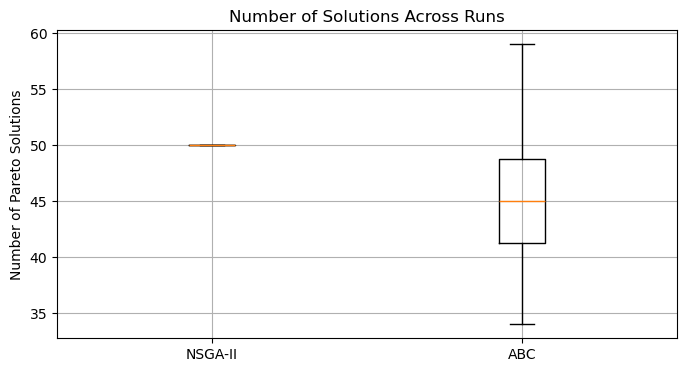

,run,algorithm,num_solutions,hypervolume,time_sec
0,1,NSGA-II,50.000000,5.815473,13.413732
1,1,ABC,45.000000,6.526078,11.382869
2,2,NSGA-II,50.000000,4.995486,13.468917
3,2,ABC,54.000000,9.07586,11.878011
4,3,NSGA-II,50.000000,4.65311,12.894565
...,...,...,...,...,...
56,29,NSGA-II,50.000000,4.950903,12.36444
57,29,ABC,53.000000,8.039784,10.924414
58,30,NSGA-II,50.000000,5.883231,12.238607
59,30,ABC,42.000000,7.728797,10.890437


In [378]:
from deap import base, creator, tools, algorithms
from scipy import stats
import time
import json

# 1️⃣ Simulated Data (5 Assets)
np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=252)
prices_df = pd.DataFrame(
    np.cumprod(1 + np.random.randn(252, 5) / 100, axis=0) * 100,
    index=dates,
    columns=["A", "B", "C", "D", "E"]
)
esg_scores = np.array([85, 80, 75, 70, 65])

# 2️⃣ Portfolio Objective & Repair Functions
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    portfolio_return = np.dot(weights, mean_annual_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)
    esg_score = np.dot(weights, esg_vector)
    return sharpe_ratio, esg_score

def repair_weights(weights, min_w=0.05, max_w=0.3):
    weights = np.nan_to_num(weights, nan=min_w)
    weights = np.clip(weights, min_w, max_w)
    total = np.sum(weights)
    if total == 0:
        weights = np.ones_like(weights) / len(weights)
    return weights / np.sum(weights)

def custom_mutation(ind, indpb=0.2):
    for i in range(len(ind)):
        if np.random.rand() < indpb:
            ind[i] += np.random.normal(0, 0.05)
    ind[:] = repair_weights(ind)
    return ind,

# 3️⃣ NSGA-II Setup
if not hasattr(creator, "FitnessMulti"):
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
if not hasattr(creator, "Individual"):
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: np.random.uniform(0.01, 0.2))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: repair_weights(np.random.rand(len(esg_scores))))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def safe_evaluate(w):
    try:
        result = evaluate_objectives(w, prices_df, esg_scores)
        if not all(np.isfinite(result)):
            return (1e6, 1e6)
        return tuple(-v for v in result)
    except:
        return (1e6, 1e6)

toolbox.register("evaluate", safe_evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selNSGA2)

def run_nsga():
    pop = toolbox.population(n=50)
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for _ in range(50):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)
        for i in range(len(offspring)):
            mutated, = toolbox.mutate(offspring[i])
            offspring[i][:] = repair_weights(mutated)
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])
        pop = toolbox.select(pop + offspring, k=50)

    front = []
    for ind in pop:
        if hasattr(ind.fitness, "values") and len(ind.fitness.values) == 2:
            if all(np.isfinite(ind.fitness.values)):
                sharpe = -ind.fitness.values[0]
                esg = -ind.fitness.values[1]
                front.append((sharpe, esg))
    return front

# 4️⃣ Your ABC Wrapper (must be defined before running this)
# def run_abc(prices_df, esg_scores, num_bees=20, max_cycles=50):
#     ...

# 5️⃣ Pareto Front Metrics
def evaluate_front(front):
    num_solutions = len(front)
    if num_solutions > 1:
        arr = np.array(front)
        arr = arr[arr[:,1].argsort()]
        hv = np.trapz(arr[:,0], arr[:,1])
    else:
        hv = 0
    return num_solutions, hv

# 6️⃣ Run 30 Trials, Save Summaries & Full Solutions
n_runs = 30
results = []
all_solutions = {}

for run in range(1, n_runs + 1):
    print(f"Running trial {run}...")

    # NSGA-II
    start = time.time()
    nsga_front = run_nsga()
    nsga_time = time.time() - start
    nsga_count, nsga_hv = evaluate_front(nsga_front)

    # ABC
    start = time.time()
    abc_all = run_abc(prices_df, esg_scores, num_bees=20, max_cycles=50)
    abc_time = time.time() - start
    abc_front = [(s, e) for (s, e, w) in abc_all if np.isfinite(s) and np.isfinite(e)]
    abc_count, abc_hv = evaluate_front(abc_front)

    results.append({"run": run, "algorithm": "NSGA-II", "num_solutions": nsga_count, "hypervolume": nsga_hv, "time_sec": nsga_time})
    results.append({"run": run, "algorithm": "ABC", "num_solutions": abc_count, "hypervolume": abc_hv, "time_sec": abc_time})

    all_solutions[f"run_{run}"] = {
        "NSGA-II": nsga_front,
        "ABC": abc_front
    }

# Save all solutions to JSON
with open("all_pareto_solutions.json", "w") as f:
    json.dump(all_solutions, f, indent=2)

# 7️⃣ Compute p-value and Save Results
df_results = pd.DataFrame(results)
nsga_counts = df_results[df_results.algorithm == "NSGA-II"]["num_solutions"].values
abc_counts  = df_results[df_results.algorithm == "ABC"]["num_solutions"].values
t_stat, p_val = stats.ttest_rel(nsga_counts, abc_counts)

print(f"\nPaired t-test on number of solutions: t = {t_stat:.3f}, p = {p_val:.3e}")

df_results.loc[len(df_results)] = {"run": "p-value", "algorithm": "NSGA-II_vs_ABC", "num_solutions": p_val, "hypervolume": "", "time_sec": ""}
df_results.to_csv("ABC_vs_NSGAII_Benchmark.csv", index=False)

# 8️⃣ Plot Distributions
plt.figure(figsize=(8, 4))
plt.boxplot([nsga_counts, abc_counts], tick_labels=["NSGA-II", "ABC"])
plt.ylabel("Number of Pareto Solutions")
plt.title("Number of Solutions Across Runs")
plt.grid(True)
plt.show()

# 9️⃣ Display Summary Table
df_results


Running trial 1...
Running trial 2...
Running trial 3...
Running trial 4...
Running trial 5...
Running trial 6...
Running trial 7...
Running trial 8...
Running trial 9...
Running trial 10...
Running trial 11...
Running trial 12...
Running trial 13...
Running trial 14...
Running trial 15...
Running trial 16...
Running trial 17...
Running trial 18...
Running trial 19...
Running trial 20...
Running trial 21...
Running trial 22...
Running trial 23...
Running trial 24...
Running trial 25...
Running trial 26...
Running trial 27...
Running trial 28...
Running trial 29...
Running trial 30...

Paired t-test on number of solutions: t = 38.647, p = 1.692e-26


C:\Users\mdars\AppData\Local\Temp\ipykernel_25248\3222527440.py:177: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nsga_counts, abc_counts], labels=["NSGA-II", "ABC"])


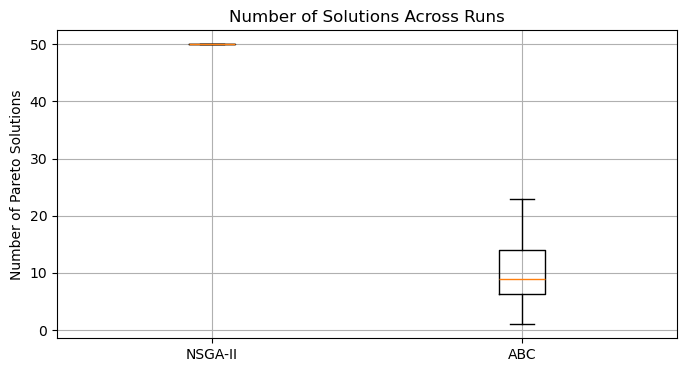

,run,algorithm,num_solutions,hypervolume,time_sec
0,1,NSGA-II,5.000000e+01,-0.428173,17.289925
1,1,ABC,3.000000e+00,0.028746,12.720816
2,2,NSGA-II,5.000000e+01,-0.482265,17.11823
3,2,ABC,1.400000e+01,0.206526,12.766961
4,3,NSGA-II,5.000000e+01,-0.638076,17.078199
...,...,...,...,...,...
56,29,NSGA-II,5.000000e+01,-0.727364,17.441679
57,29,ABC,9.000000e+00,3.263911,12.581052
58,30,NSGA-II,5.000000e+01,-0.492782,17.09712
59,30,ABC,1.000000e+01,0.695363,12.749467


In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from scipy import stats
import time
import json
from datetime import datetime

# 1️⃣ Simulated Data (20 Assets Example)
np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=252)
prices_df = pd.DataFrame(
    np.cumprod(1 + np.random.randn(252, 20) / 100, axis=0) * 100,
    index=dates,
    columns=[f"Stock_{i+1}" for i in range(20)]
)
esg_scores = np.array([87, 83, 81, 79, 77, 75, 74, 73, 72, 71, 70, 69, 68, 66, 65, 64, 63, 62, 61, 60])

# 2️⃣ Portfolio Objective & Repair Functions
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    portfolio_return = np.dot(weights, mean_annual_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)
    esg_score = np.dot(weights, esg_vector)
    return sharpe_ratio, esg_score

def repair_weights(weights, min_w=0.05, max_w=0.3):
    weights = np.nan_to_num(weights, nan=min_w)
    weights = np.clip(weights, min_w, max_w)
    total = np.sum(weights)
    if total == 0:
        weights = np.ones_like(weights) / len(weights)
    return weights / np.sum(weights)

def custom_mutation(ind, indpb=0.2):
    for i in range(len(ind)):
        if np.random.rand() < indpb:
            ind[i] += np.random.normal(0, 0.05)
    ind[:] = repair_weights(ind)
    return ind,

# 3️⃣ NSGA-II Setup
if not hasattr(creator, "FitnessMulti"):
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
if not hasattr(creator, "Individual"):
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: np.random.uniform(0.01, 0.2))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: repair_weights(np.random.rand(len(esg_scores))))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def safe_evaluate(w):
    try:
        result = evaluate_objectives(w, prices_df, esg_scores)
        if not all(np.isfinite(result)):
            return (1e6, 1e6)
        return tuple(-v for v in result)
    except:
        return (1e6, 1e6)

toolbox.register("evaluate", safe_evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selNSGA2)

def run_nsga():
    pop = toolbox.population(n=50)
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for _ in range(50):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)
        for i in range(len(offspring)):
            mutated, = toolbox.mutate(offspring[i])
            offspring[i][:] = repair_weights(mutated)
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])
        pop = toolbox.select(pop + offspring, k=50)

    front = []
    for ind in pop:
        if hasattr(ind.fitness, "values") and len(ind.fitness.values) == 2:
            if all(np.isfinite(ind.fitness.values)):
                sharpe = -ind.fitness.values[0]
                esg = -ind.fitness.values[1]
                weights = ind.tolist()
                front.append({"sharpe": sharpe, "esg": esg, "weights": weights})
    return front

# 4️⃣ Your ABC Wrapper (define before running this)
# def run_abc(prices_df, esg_scores, num_bees=20, max_cycles=50):
#     return [(sharpe, esg, weights), ...]

# 5️⃣ Pareto Front Metrics
def evaluate_front(front):
    num_solutions = len(front)
    if num_solutions > 1:
        arr = np.array([[s["sharpe"], s["esg"]] for s in front])
        arr = arr[arr[:,1].argsort()]
        hv = np.trapz(arr[:,0], arr[:,1])
    else:
        hv = 0
    return num_solutions, hv

# 6️⃣ Run 30 Trials, Save Summaries & Full Solutions
n_runs = 30
results = []
all_solutions = {}

for run in range(1, n_runs + 1):
    print(f"Running trial {run}...")

    all_solutions[f"run_{run}"] = {
        "timestamp": datetime.now().isoformat(),
        "NSGA-II": {},
        "ABC": {}
    }

    # NSGA-II
    start = time.time()
    nsga_front = run_nsga()
    nsga_time = time.time() - start
    nsga_count, nsga_hv = evaluate_front(nsga_front)
    all_solutions[f"run_{run}"]["NSGA-II"] = {
        "time_sec": nsga_time,
        "solutions": nsga_front
    }

    # ABC
    start = time.time()
    abc_all = run_abc(prices_df, esg_scores, num_bees=20, max_cycles=50)
    abc_time = time.time() - start
    abc_front = [{"sharpe": s, "esg": e, "weights": list(w)} for (s, e, w) in abc_all if np.isfinite(s) and np.isfinite(e)]
    abc_count, abc_hv = evaluate_front(abc_front)
    all_solutions[f"run_{run}"]["ABC"] = {
        "time_sec": abc_time,
        "solutions": abc_front
    }

    results.append({"run": run, "algorithm": "NSGA-II", "num_solutions": nsga_count, "hypervolume": nsga_hv, "time_sec": nsga_time})
    results.append({"run": run, "algorithm": "ABC", "num_solutions": abc_count, "hypervolume": abc_hv, "time_sec": abc_time})

# Save all solutions to JSON
with open("all_pareto_solutions_20.json", "w") as f:
    json.dump(all_solutions, f, indent=2)

# 7️⃣ Compute p-value and Save Results
df_results = pd.DataFrame(results)
nsga_counts = df_results[df_results.algorithm == "NSGA-II"]["num_solutions"].values
abc_counts  = df_results[df_results.algorithm == "ABC"]["num_solutions"].values
t_stat, p_val = stats.ttest_rel(nsga_counts, abc_counts)

print(f"\nPaired t-test on number of solutions: t = {t_stat:.3f}, p = {p_val:.3e}")

df_results.loc[len(df_results)] = {"run": "p-value", "algorithm": "NSGA-II_vs_ABC", "num_solutions": p_val, "hypervolume": "", "time_sec": ""}
df_results.to_csv("ABC_vs_NSGAII_Benchmark_20.csv", index=False)

# 8️⃣ Plot Distributions
plt.figure(figsize=(8, 4))
plt.boxplot([nsga_counts, abc_counts], labels=["NSGA-II", "ABC"])
plt.ylabel("Number of Pareto Solutions")
plt.title("Number of Solutions Across Runs")
plt.grid(True)
plt.show()

# 9️⃣ Display Summary Table
df_results


In [384]:
import pandas as pd

# Load the CSV
af = pd.read_csv("ABC_vs_NSGAII_Benchmark.csv")

# Convert to LaTeX code
latex_table = af.to_latex(index=False, float_format="%.3f")
print(latex_table)

\begin{tabular}{llrrr}
\toprule
run & algorithm & num_solutions & hypervolume & time_sec \\
\midrule
1 & NSGA-II & 50.000 & 5.815 & 13.414 \\
1 & ABC & 45.000 & 6.526 & 11.383 \\
2 & NSGA-II & 50.000 & 4.995 & 13.469 \\
2 & ABC & 54.000 & 9.076 & 11.878 \\
3 & NSGA-II & 50.000 & 4.653 & 12.895 \\
3 & ABC & 46.000 & 7.724 & 10.817 \\
4 & NSGA-II & 50.000 & 4.670 & 12.176 \\
4 & ABC & 41.000 & 6.406 & 10.807 \\
5 & NSGA-II & 50.000 & 4.692 & 12.704 \\
5 & ABC & 44.000 & 4.515 & 11.357 \\
6 & NSGA-II & 50.000 & 5.170 & 13.949 \\
6 & ABC & 38.000 & 7.630 & 11.249 \\
7 & NSGA-II & 50.000 & 4.667 & 12.725 \\
7 & ABC & 44.000 & 8.186 & 10.867 \\
8 & NSGA-II & 50.000 & 4.735 & 12.342 \\
8 & ABC & 36.000 & 6.701 & 10.922 \\
9 & NSGA-II & 50.000 & 4.804 & 12.530 \\
9 & ABC & 47.000 & 6.646 & 11.060 \\
10 & NSGA-II & 50.000 & 4.819 & 12.596 \\
10 & ABC & 51.000 & 6.713 & 10.546 \\
11 & NSGA-II & 50.000 & 4.815 & 12.316 \\
11 & ABC & 40.000 & 7.183 & 10.454 \\
12 & NSGA-II & 50.000 & 4.632 & 12.24

In [386]:
import pandas as pd

# Load the CSV
af = pd.read_csv("ABC_vs_NSGAII_Benchmark_20.csv")

# Convert to LaTeX code
latex_table = af.to_latex(index=False, float_format="%.3f")
print(latex_table)

\begin{tabular}{llrrr}
\toprule
run & algorithm & num_solutions & hypervolume & time_sec \\
\midrule
1 & NSGA-II & 50.000 & -0.428 & 17.290 \\
1 & ABC & 3.000 & 0.029 & 12.721 \\
2 & NSGA-II & 50.000 & -0.482 & 17.118 \\
2 & ABC & 14.000 & 0.207 & 12.767 \\
3 & NSGA-II & 50.000 & -0.638 & 17.078 \\
3 & ABC & 10.000 & 1.534 & 13.252 \\
4 & NSGA-II & 50.000 & -0.477 & 17.126 \\
4 & ABC & 9.000 & 3.420 & 12.853 \\
5 & NSGA-II & 50.000 & -0.862 & 17.036 \\
5 & ABC & 15.000 & 1.467 & 12.894 \\
6 & NSGA-II & 50.000 & -0.552 & 17.138 \\
6 & ABC & 1.000 & 0.000 & 12.623 \\
7 & NSGA-II & 50.000 & -0.817 & 17.053 \\
7 & ABC & 1.000 & 0.000 & 12.681 \\
8 & NSGA-II & 50.000 & -0.593 & 17.641 \\
8 & ABC & 23.000 & 2.309 & 12.860 \\
9 & NSGA-II & 50.000 & -0.547 & 17.502 \\
9 & ABC & 9.000 & 0.944 & 12.731 \\
10 & NSGA-II & 50.000 & -0.510 & 17.104 \\
10 & ABC & 10.000 & 0.263 & 12.770 \\
11 & NSGA-II & 50.000 & -0.693 & 17.488 \\
11 & ABC & 5.000 & 0.213 & 12.815 \\
12 & NSGA-II & 50.000 & -0.496 &